In [1]:
%matplotlib inline


# Plot the decision surface of decision trees trained on the iris dataset

Plot the decision surface of a decision tree trained on pairs
of features of the iris dataset.

See `decision tree <tree>` for more information on the estimator.

For each pair of iris features, the decision tree learns decision
boundaries made of combinations of simple thresholding rules inferred from
the training samples.

We also show the tree structure of a model built on all of the features.


First load the copy of the Iris dataset shipped with scikit-learn:



In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

Display the decision functions of trees trained on all pairs of features.



/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_5765/3884067348.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


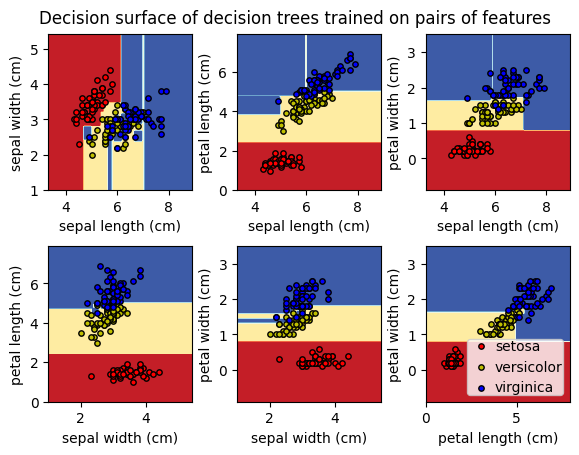

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay


# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

Display the structure of a single decision tree trained on all the features
together.



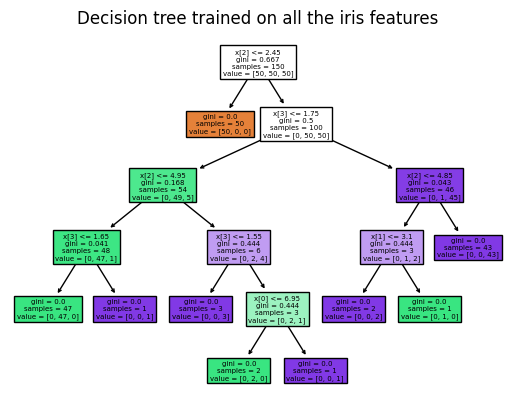

In [4]:
from sklearn.tree import plot_tree

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [5]:
from sklearn.tree import export_text

In [6]:
r = export_text(clf, feature_names=iris['feature_names'])
print(r)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- sepal length (cm) <= 6.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sepal length (cm) >  6.95
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



Below is the section that translates from the decision tree to the ZoKrates code, which is one of the main components of this hackathon implementation.

In [8]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict(field {}) -> field {{".format(", field ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node].replace(" ", "_")[:-5]
            threshold = tree_.threshold[node]
            if depth == 1:
                print("{}return if {} <= {} {{".format(indent, name, int(np.round(threshold*100,0))))
            else:
                print("{}if {} <= {} {{".format(indent, name, int(np.round(threshold*100,0))))
            recurse(tree_.children_left[node], depth + 1)
            print("{} }}".format(indent))
            print("{}else {{".format(indent, name, int(np.round(threshold*100,0))))
            recurse(tree_.children_right[node], depth + 1)
            if depth == 1:
                print("{} }};".format(indent))
            else:
                print("{} }}".format(indent))
        else:
            print("{} {}".format(indent, np.argmax(tree_.value[node][0])))
    recurse(0, 1)
    print("}")

In [9]:
c = tree_to_code(clf, feature_names=iris['feature_names']);
print(c)

def predict(field sepal_length, field sepal_width, field petal_length, field petal_width) -> field {
    return if petal_length <= 245 {
         0
     }
    else {
        if petal_width <= 175 {
            if petal_length <= 495 {
                if petal_width <= 165 {
                     1
                 }
                else {
                     2
                 }
             }
            else {
                if petal_width <= 155 {
                     2
                 }
                else {
                    if sepal_length <= 695 {
                         1
                     }
                    else {
                         2
                     }
                 }
             }
         }
        else {
            if petal_length <= 485 {
                if sepal_width <= 310 {
                     2
                 }
                else {
                     1
                 }
             }
            else {
                 2
          